In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU available.")
else:
    print("GPU is not available.")

GPU available.


# Problem Statement

The goal of this assignment is to create a model to detectify metasstatic cancer in a small image patch taken from larger digital pathology scans. Each submission is evaluated on area under the ROC curve between the predicted probability and the observed target. 

# EDA

Files are named with an image id. train_labels.csv contains the ground truth for the images in the trian folder. We predict the labels for the images in the test folder. 

A positive label (1) is indicative that a region of the patch from the scan contains at least one pixel of tumor tissue. (Tumor tissue in the outer region ofthe patch does NOT influence the label). 0 Indicates that a region of the patch from the scan did not contain any tumor tissue. 

The Kaggle dataset that we are using does not contain any duplicatess.

Image resolution is an important factor, so I will check the resolution of the images, along with the count of images that found tumor tissue to check if the data is balanced, and look at sample images (in additional to manual inspection) to determine if there are any other features that should be used before building the model. 

In [2]:
import os
import pandas as pd

train_path = r'C:\Users\josea\OneDrive\Desktop\Histopathologic Cancer Detection\train'

In [3]:
files = os.listdir(train_path)
image_files = [file for file in files if any(file)]
len(image_files)
num_images = len(image_files)

print(f'Total number of images: {num_images}')


Total number of images: 220025


In [4]:
from PIL import Image
import os
from concurrent.futures import ThreadPoolExecutor

# Set the path to the training directory containing your images
train_path = r'C:\Users\josea\OneDrive\Desktop\Histopathologic Cancer Detection\train'

# Dictionary to store counts for each resolution
resolution_counts = {}

def process_image(image_file):
    image_path = os.path.join(train_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        resolution = f"{width} x {height}"
        return resolution

# Use ThreadPoolExecutor for parallelization
with ThreadPoolExecutor() as executor:
    resolutions = list(executor.map(process_image, [file for file in os.listdir(train_path) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tif'))]))

# Update the count for each resolution
for resolution in resolutions:
    resolution_counts[resolution] = resolution_counts.get(resolution, 0) + 1

# Print the counts for each resolution
for resolution, count in resolution_counts.items():
    print(f"Resolution: {resolution}, Count: {count}")

Resolution: 96 x 96, Count: 220025


ALl the images have 96 x 96 resolution. Therefore, we do not have to do any pre-processing to standardize the image resolutions. 

In [5]:
import os
import pandas as pd

# Set the path to the train_labels.csv file
train_labels = r'C:\Users\josea\OneDrive\Desktop\Histopathologic Cancer Detection\train_labels.csv'

# Set the path to the training directory containing your images
train_path = r'C:\Users\josea\OneDrive\Desktop\Histopathologic Cancer Detection\train'

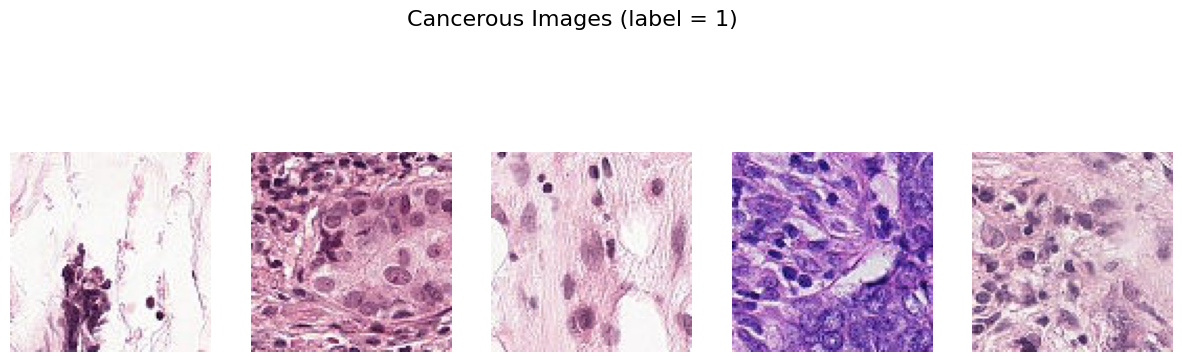

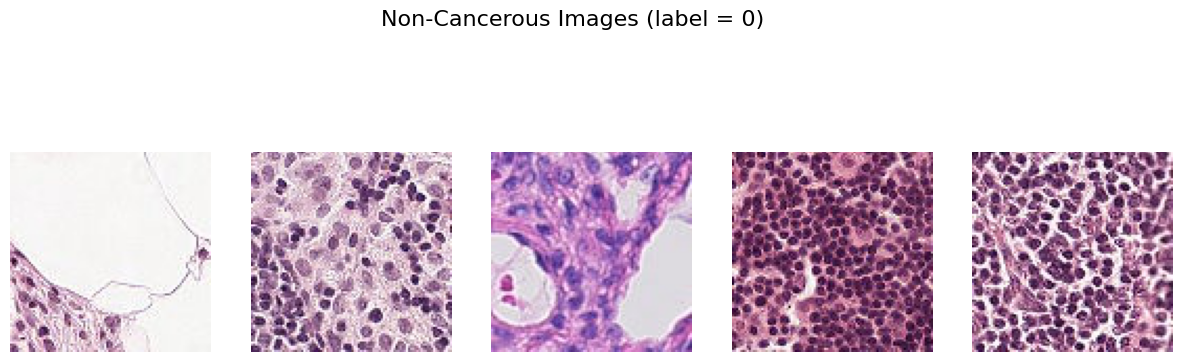

In [6]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load train_labels.csv into a Pandas DataFrame
df_labels = pd.read_csv(train_labels)

# Filter out rows where the label is 1 (cancerous)
cancerous_images = df_labels[df_labels['label'] == 1].head(5)

# Filter out rows where the label is 0 (non-cancerous)
non_cancerous_images = df_labels[df_labels['label'] == 0].head(5)

# Function to display images
def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for i, image_path in enumerate(image_paths):
        plt.subplot(1, 5, i + 1)
        img = mpimg.imread(os.path.join(train_path, f"{image_path}.tif"))
        plt.imshow(img)
        plt.axis('off')

    plt.show()

# Display 5 cancerous images
display_images(cancerous_images['id'].values, title='Cancerous Images (label = 1)')

# Display 5 non-cancerous images
display_images(non_cancerous_images['id'].values, title='Non-Cancerous Images (label = 0)')

# Model Training

For this model, I will use a Convolutional Neural Network (CNN) using PyTorch. The CNN architecture is well-suited for image recognition tasks as it is able to capture hierarchical patterns in the data. 

The training process will involve feeding and preprocessing images to the network, allowing the network to learn from patterns associated with metastatic tissues.  

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import os

# Set random seed for reproducibility
torch.manual_seed(42)

# Define a custom dataset
class CancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.df.iloc[idx, 0]}.tif")
        image = Image.open(img_name)
        label = torch.tensor(self.df.iloc[idx, 1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_labels, test_size=0.2, random_state=42)

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.ToTensor(),
])

# Create datasets and data loaders
train_dataset = CancerDataset(train_df, train_path, transform=transform)
test_dataset = CancerDataset(test_df, train_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 32 * 32, 1) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            average_loss = running_loss / (batch_idx + 1)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{total_batches}], Loss: {average_loss:.4f}')

# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item()
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

average_test_loss = test_loss / len(test_loader)
accuracy = correct / total

print(f'Average Test Loss: {average_test_loss:.4f}')
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')

Epoch [1/2], Batch [10/1376], Loss: 0.6579
Epoch [1/2], Batch [20/1376], Loss: 0.6448
Epoch [1/2], Batch [30/1376], Loss: 0.6367
Epoch [1/2], Batch [40/1376], Loss: 0.6228
Epoch [1/2], Batch [50/1376], Loss: 0.6099
Epoch [1/2], Batch [60/1376], Loss: 0.5982
Epoch [1/2], Batch [70/1376], Loss: 0.5875
Epoch [1/2], Batch [80/1376], Loss: 0.5789
Epoch [1/2], Batch [90/1376], Loss: 0.5723
Epoch [1/2], Batch [100/1376], Loss: 0.5680
Epoch [1/2], Batch [110/1376], Loss: 0.5634
Epoch [1/2], Batch [120/1376], Loss: 0.5572
Epoch [1/2], Batch [130/1376], Loss: 0.5510
Epoch [1/2], Batch [140/1376], Loss: 0.5453
Epoch [1/2], Batch [150/1376], Loss: 0.5418
Epoch [1/2], Batch [160/1376], Loss: 0.5400
Epoch [1/2], Batch [170/1376], Loss: 0.5366
Epoch [1/2], Batch [180/1376], Loss: 0.5347
Epoch [1/2], Batch [190/1376], Loss: 0.5320
Epoch [1/2], Batch [200/1376], Loss: 0.5303
Epoch [1/2], Batch [210/1376], Loss: 0.5296
Epoch [1/2], Batch [220/1376], Loss: 0.5277
Epoch [1/2], Batch [230/1376], Loss: 0.52

In [8]:
# Set the path to the test directory containing your images
test_path = r'C:\Users\josea\OneDrive\Desktop\Histopathologic Cancer Detection\test'

# Define the TestDataset class for test data
class TestCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_file)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_file.replace('.tif', '')  # Return the image and extracted id

# Create the test dataset and DataLoader
test_dataset = TestCancerDataset(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Make predictions on the test set
model.eval()
predictions = []
image_ids = []

with torch.no_grad():
    for inputs, ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        predictions.extend(predicted.cpu().numpy())
        image_ids.extend(ids)

# Create a DataFrame with image ids and predictions
submission_df = pd.DataFrame({'id': image_ids, 'label': predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

In [9]:
# Assuming test_dataset is a list of tuples where each tuple contains (image, id)
ids = [item[1] for item in test_dataset]
submission_df = pd.DataFrame({'id': ids, 'label': predictions})

In [10]:
submission_df.to_csv('submission.csv', index=False)

# Results

The model scored 0.7734 in the public score.

There are several methods that could be utilized for future improvements of the model.
* Use a pre-trained model such as ResNeXt-50
* Augment the data by rotating, flipping images to re-use
